# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:
import yaml
import itertools
from pathlib import Path

In [4]:
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers

In [5]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [6]:
_, _, _, zhist_emd, _ = load_groups('group_emd_80_300.npz')

In [7]:
_, _, _, zhist_wgt, _ = load_groups('group_wgt_80_300.npz')

In [8]:
_, _, _, zhist_cos, _ = load_groups('group_cos_80_300.npz')

In [9]:
init_data = load_binned('binned_80_4k.npz')

## Optimize using redshifts directly

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [10]:
from tomo_challenge import load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [11]:
zds = np.asarray(init_data[0])

In [12]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [13]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [14]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

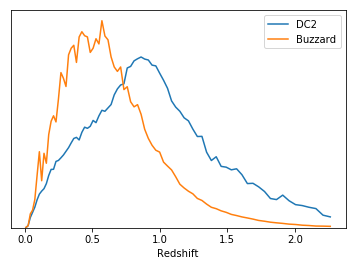

In [15]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [25]:
def optimize_direct(nbin, ntrial, nsteps, eta, transform, metric, method, seed, dndz_total=dndz_buz, init_data=init_data):
    mixing = jnp.diag(dndz_total)
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

In [27]:
def run_study(path, func, rerun=[]):
    path = Path(path)
    with open(path / 'config.yaml') as f:
        config = yaml.safe_load(f)
    nstudy = len(config['nbin'])
    argsiter = []
    argnames = config.keys()
    for arg in argnames:
        if not isinstance(config[arg], list):
            argsiter.append(itertools.repeat(config[arg]))
        elif len(config[arg]) != nstudy:
            print(f'Expected 1 or {nstudy} values for {arg}.')
            return
        else:
            argsiter.append(iter(config[arg]))
    for argvalues in zip(*argsiter):
        kw = dict(zip(argnames, argvalues))
        nbin = kw['nbin']
        outpath = path / f'nbin-{nbin}'
        if not outpath.exists():
            outpath.mkdir()          
        if (not rerun == 'all') and (nbin not in rerun) and (outpath / f'scores-{nbin}.yaml').exists():
            # Assume that this job has already run successfully.
            print(f'Skipping already completed job for nbin={nbin}')
            continue
        # Run the optimization for this nbin.
        print(f'Running job with {kw}')
        best_scores, dndz_bin, all_scores = func(**kw)
        # Save the results to outpath.
        np.savez(outpath / f'dndz-{nbin}.npz', dndz=dndz_bin, zedges=init_data[0])
        for scores in all_scores:
            plt.plot(scores, 'r-', alpha=0.3)
        plt.xlabel('Optimization step')
        plt.ylabel(kw.get('metric', 'Score'))
        plt.savefig(outpath / f'training-{nbin}.png')
        plt.show()
        plot_dndz(dndz_bin, init_data[0])
        plt.savefig(outpath / f'dndz-{nbin}.png')
        plt.show()
        with open(outpath / f'scores-{nbin}.yaml', 'w') as f:
            yaml.dump(best_scores, f)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=955.378 (max=955.378) after 375 steps.
  score=957.029 (max=957.029) after 750 steps.
  score=957.539 (max=957.539) after 1125 steps.
  score=957.742 (max=957.742) after 1500 steps.
trial 1/10: score=957.742 (max=957.742) after 1500 steps.
  score=955.202 (max=957.742) after 375 steps.
  score=956.868 (max=957.742) after 750 steps.
  score=957.369 (max=957.742) after 1125 steps.
  score=957.594 (max=957.742) after 1500 steps.
trial 2/10: score=957.594 (max=957.742) after 1500 steps.
  score=954.191 (max=957.742) after 375 steps.
  score=956.359 (max=957.742) after 750 steps.
  score=957.038 (max=957.742) after 1125 steps.
  score=957.350 (max=957.742) after 1500 steps.
trial 3/10: score=957.350 (max=957.742) after 1500 steps.
  score=955.291 (max=957.742) after 375 steps.
  score=957.353 (max=957.742) after 750 steps.
  score=958.043 

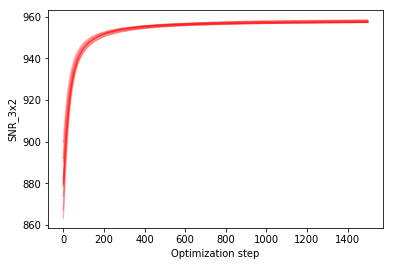

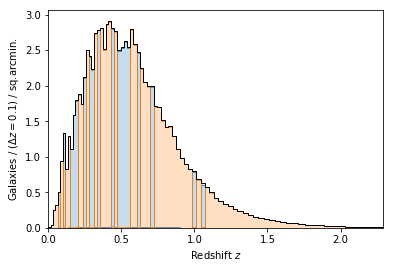

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1346.926 (max=1346.926) after 750 steps.
  score=1352.082 (max=1352.082) after 1500 steps.
  score=1353.684 (max=1353.684) after 2250 steps.
  score=1354.442 (max=1354.442) after 3000 steps.
trial 1/10: score=1354.442 (max=1354.442) after 3000 steps.
  score=1344.148 (max=1354.442) after 750 steps.
  score=1349.034 (max=1354.442) after 1500 steps.
  score=1350.328 (max=1354.442) after 2250 steps.
  score=1350.891 (max=1354.442) after 3000 steps.
trial 2/10: score=1350.891 (max=1354.442) after 3000 steps.
  score=1345.514 (max=1354.442) after 750 steps.
  score=1350.004 (max=1354.442) after 1500 steps.
  score=1351.198 (max=1354.442) after 2250 steps.
  score=1351.718 (max=1354.442) after 3000 steps.
trial 3/10: score=1351.718 (max=1354.442) after 3000 steps.
  score=1344.137 (max=1354.442) after 750 steps.
  score=1349.929 (max=1354.4

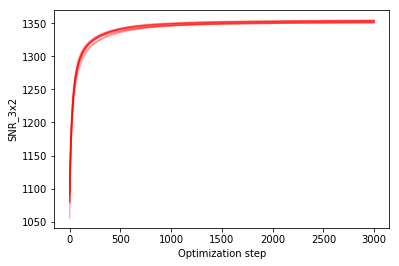

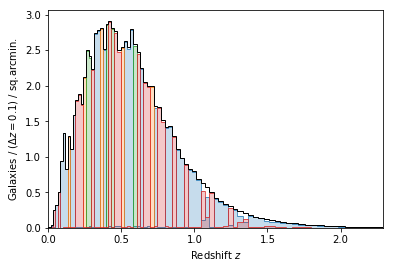

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1645.812 (max=1645.812) after 1125 steps.
  score=1652.883 (max=1652.883) after 2250 steps.
  score=1654.487 (max=1654.487) after 3375 steps.
  score=1655.104 (max=1655.104) after 4500 steps.
trial 1/10: score=1655.104 (max=1655.104) after 4500 steps.
  score=1647.855 (max=1655.104) after 1125 steps.
  score=1655.254 (max=1655.254) after 2250 steps.
  score=1657.029 (max=1657.029) after 3375 steps.
  score=1657.660 (max=1657.660) after 4500 steps.
trial 2/10: score=1657.660 (max=1657.660) after 4500 steps.
  score=1649.409 (max=1657.660) after 1125 steps.
  score=1655.465 (max=1657.660) after 2250 steps.
  score=1657.036 (max=1657.660) after 3375 steps.
  score=1657.723 (max=1657.723) after 4500 steps.
trial 3/10: score=1657.723 (max=1657.723) after 4500 steps.
  score=1650.620 (max=1657.723) after 1125 steps.
  score=1657.722 (max=16

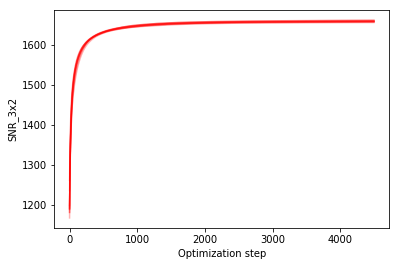

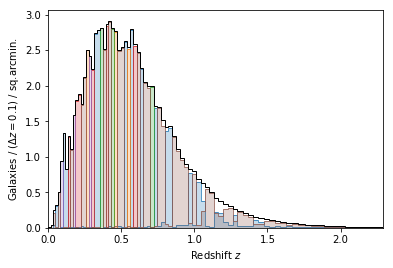

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1901.542 (max=1901.542) after 1500 steps.
  score=1908.733 (max=1908.733) after 3000 steps.
  score=1910.630 (max=1910.630) after 4500 steps.
  score=1911.375 (max=1911.375) after 6000 steps.
trial 1/10: score=1911.375 (max=1911.375) after 6000 steps.
  score=1905.131 (max=1911.375) after 1500 steps.
  score=1911.519 (max=1911.519) after 3000 steps.
  score=1913.373 (max=1913.373) after 4500 steps.
  score=1914.083 (max=1914.083) after 6000 steps.
trial 2/10: score=1914.083 (max=1914.083) after 6000 steps.
  score=1905.137 (max=1914.083) after 1500 steps.
  score=1913.101 (max=1914.083) after 3000 steps.
  score=1915.060 (max=1915.060) after 4500 steps.
  score=1915.775 (max=1915.775) after 6000 steps.
trial 3/10: score=1915.775 (max=1915.775) after 6000 steps.
  score=1908.236 (max=1915.775) after 1500 steps.
  score=1914.880 (max=19

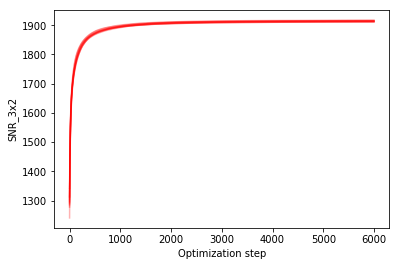

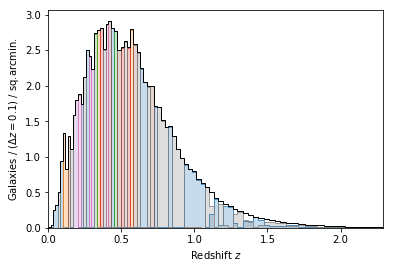

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=2130.203 (max=2130.203) after 1875 steps.
  score=2138.088 (max=2138.088) after 3750 steps.
  score=2140.043 (max=2140.043) after 5625 steps.
  score=2140.643 (max=2140.643) after 7500 steps.
trial 1/10: score=2140.643 (max=2140.643) after 7500 steps.
  score=2133.722 (max=2140.643) after 1875 steps.
  score=2140.645 (max=2140.645) after 3750 steps.
  score=2142.331 (max=2142.331) after 5625 steps.
  score=2142.973 (max=2142.974) after 7500 steps.
trial 2/10: score=2142.973 (max=2142.974) after 7500 steps.
  score=2130.392 (max=2142.974) after 1875 steps.
  score=2139.948 (max=2142.974) after 3750 steps.
  score=2141.925 (max=2142.974) after 5625 steps.
  score=2142.584 (max=2142.974) after 7500 steps.
trial 3/10: score=2142.584 (max=2142.974) after 7500 steps.
  score=2134.870 (max=2142.974) after 1875 steps.
  score=2144.475 (max=2

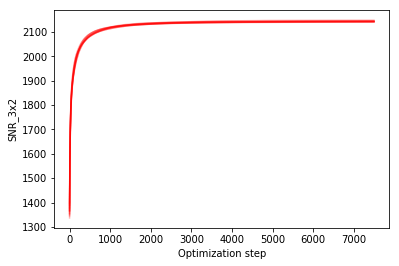

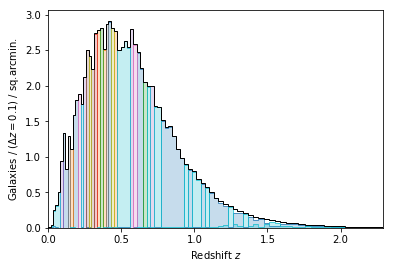

In [29]:
run_study('results/direct-snr', optimize_direct)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=806.440 (max=806.440) after 375 steps.
  score=862.701 (max=862.833) after 750 steps.
  score=863.135 (max=863.289) after 1125 steps.
  score=863.228 (max=863.413) after 1500 steps.
trial 1/10: score=863.228 (max=863.413) after 1500 steps.
  score=1369.219 (max=1369.219) after 375 steps.
  score=1372.716 (max=1372.825) after 750 steps.
  score=1373.239 (max=1373.373) after 1125 steps.
  score=1373.449 (max=1373.494) after 1500 steps.
trial 2/10: score=1373.449 (max=1373.494) after 1500 steps.
  score=1082.323 (max=1373.494) after 375 steps.
  score=1083.732 (max=1373.494) after 750 steps.
  score=1083.984 (max=1373.494) after 1125 steps.
  score=1084.249 (max=1373.494) after 1500 steps.
trial 3/10: score=1084.249 (max=1373.494) after 1500 steps.
  score=1404.424 (max=1404.424) after 375 steps.
  score=1406.828 (max=1406.850) after 750 

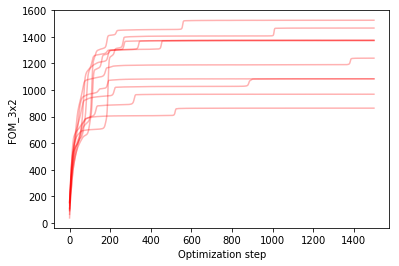

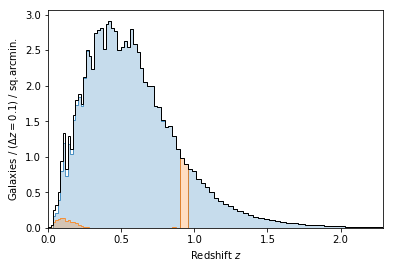

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=4196.730 (max=4196.730) after 750 steps.
  score=4208.352 (max=4208.542) after 1500 steps.
  score=4212.370 (max=4212.370) after 2250 steps.
  score=4213.755 (max=4213.860) after 3000 steps.
trial 1/10: score=4213.755 (max=4213.860) after 3000 steps.
  score=2943.353 (max=4213.860) after 750 steps.
  score=3015.012 (max=4213.860) after 1500 steps.
  score=3020.687 (max=4213.860) after 2250 steps.
  score=3022.122 (max=4213.860) after 3000 steps.
trial 2/10: score=3022.122 (max=4213.860) after 3000 steps.
  score=3398.938 (max=4213.860) after 750 steps.
  score=3535.677 (max=4213.860) after 1500 steps.
  score=3537.083 (max=4213.860) after 2250 steps.
  score=3552.062 (max=4213.860) after 3000 steps.
trial 3/10: score=3552.062 (max=4213.860) after 3000 steps.
  score=4390.188 (max=4390.582) after 750 steps.
  score=4401.930 (max=4401.96

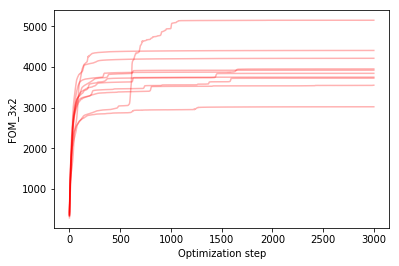

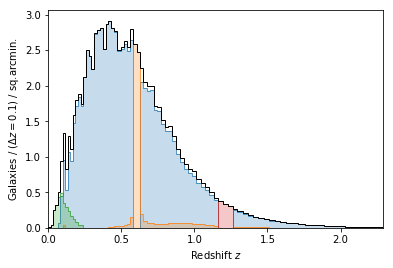

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=6117.903 (max=6121.206) after 1125 steps.
  score=6133.711 (max=6135.538) after 2250 steps.
  score=6139.951 (max=6141.189) after 3375 steps.
  score=6142.823 (max=6143.214) after 4500 steps.
trial 1/10: score=6142.823 (max=6143.214) after 4500 steps.
  score=5638.144 (max=6143.214) after 1125 steps.
  score=5659.508 (max=6143.214) after 2250 steps.
  score=5664.872 (max=6143.214) after 3375 steps.
  score=5666.871 (max=6143.214) after 4500 steps.
trial 2/10: score=5666.871 (max=6143.214) after 4500 steps.
  score=5115.425 (max=6143.214) after 1125 steps.
  score=5125.028 (max=6143.214) after 2250 steps.
  score=5128.246 (max=6143.214) after 3375 steps.
  score=5186.543 (max=6143.214) after 4500 steps.
trial 3/10: score=5186.543 (max=6143.214) after 4500 steps.
  score=5480.897 (max=6143.214) after 1125 steps.
  score=5491.989 (max=614

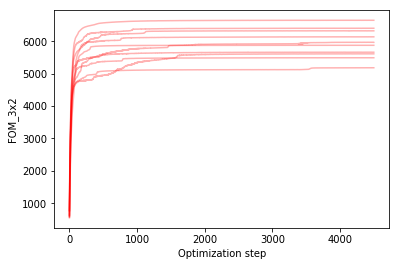

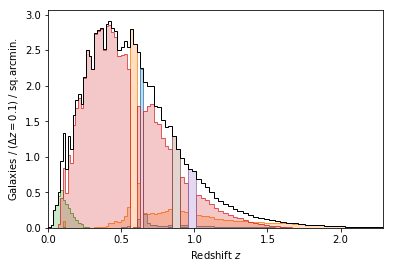

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8252.369 (max=8254.325) after 1500 steps.
  score=8305.799 (max=8307.739) after 3000 steps.
  score=8318.668 (max=8320.386) after 4500 steps.
  score=8324.377 (max=8325.323) after 6000 steps.
trial 1/10: score=8324.377 (max=8325.323) after 6000 steps.
  score=7200.022 (max=8325.323) after 1500 steps.
  score=7210.007 (max=8325.323) after 3000 steps.
  score=7213.054 (max=8325.323) after 4500 steps.
  score=7213.486 (max=8325.323) after 6000 steps.
trial 2/10: score=7213.486 (max=8325.323) after 6000 steps.
  score=7473.787 (max=8325.323) after 1500 steps.
  score=7499.862 (max=8325.323) after 3000 steps.
  score=7502.406 (max=8325.323) after 4500 steps.
  score=7502.763 (max=8325.323) after 6000 steps.
trial 3/10: score=7502.763 (max=8325.323) after 6000 steps.
  score=7671.620 (max=8325.323) after 1500 steps.
  score=7764.098 (max=832

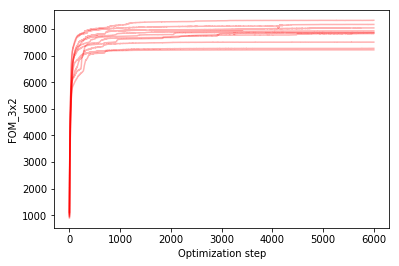

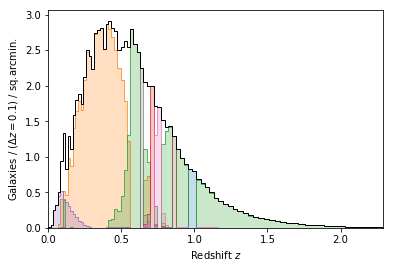

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=9133.171 (max=9135.754) after 1875 steps.
  score=9195.088 (max=9195.921) after 3750 steps.
  score=9258.403 (max=9258.403) after 5625 steps.
  score=9294.558 (max=9296.111) after 7500 steps.
trial 1/10: score=9294.558 (max=9296.111) after 7500 steps.
  score=8511.273 (max=9296.111) after 1875 steps.
  score=8562.951 (max=9296.111) after 3750 steps.
  score=8565.584 (max=9296.111) after 5625 steps.
  score=8566.770 (max=9296.111) after 7500 steps.
trial 2/10: score=8566.770 (max=9296.111) after 7500 steps.
  score=8806.664 (max=9296.111) after 1875 steps.
  score=8818.396 (max=9296.111) after 3750 steps.
  score=8822.781 (max=9296.111) after 5625 steps.
  score=8821.728 (max=9296.111) after 7500 steps.
trial 3/10: score=8821.728 (max=9296.111) after 7500 steps.
  score=8978.176 (max=9296.111) after 1875 steps.
  score=9201.920 (max=92

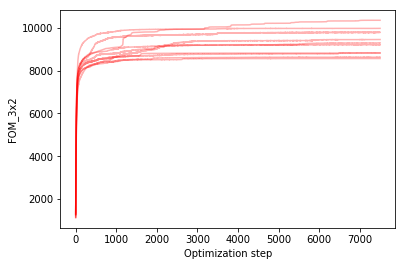

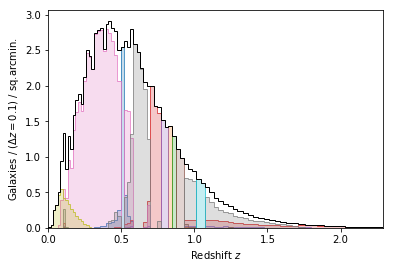

In [28]:
run_study('results/direct-fom', optimize_direct)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=20.918 (max=20.918) after 250 steps.
  score=22.061 (max=22.061) after 500 steps.
  score=22.402 (max=22.402) after 750 steps.
  score=22.520 (max=22.521) after 1000 steps.
trial 1/10: score=22.520 (max=22.521) after 1000 steps.
  score=20.319 (max=22.521) after 250 steps.
  score=21.783 (max=22.521) after 500 steps.
  score=22.253 (max=22.521) after 750 steps.
  score=22.438 (max=22.521) after 1000 steps.
trial 2/10: score=22.438 (max=22.521) after 1000 steps.
  score=20.495 (max=22.521) after 250 steps.
  score=21.868 (max=22.521) after 500 steps.
  score=22.299 (max=22.521) after 750 steps.
  score=22.461 (max=22.521) after 1000 steps.
trial 3/10: score=22.461 (max=22.521) after 1000 steps.
  score=20.717 (max=22.521) after 250 steps.
  score=21.977 (max=22.521) after 500 steps.
  score=22.341 (max=22.521) after 750 steps.
  score=22.495 (

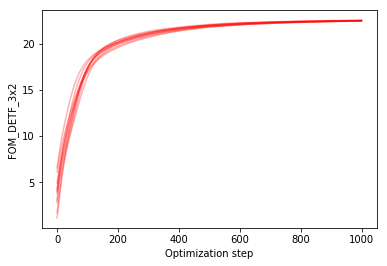

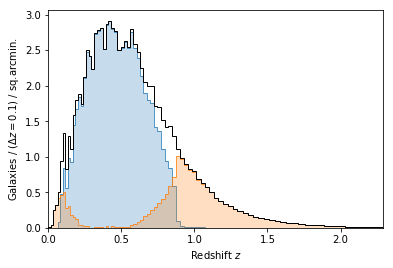

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 2000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.099 (max=63.099) after 500 steps.
  score=65.469 (max=65.481) after 1000 steps.
  score=66.134 (max=66.148) after 1500 steps.
  score=66.466 (max=66.474) after 2000 steps.
trial 1/10: score=66.466 (max=66.474) after 2000 steps.
  score=62.059 (max=66.474) after 500 steps.
  score=65.678 (max=66.474) after 1000 steps.
  score=66.659 (max=66.659) after 1500 steps.
  score=67.088 (max=67.091) after 2000 steps.
trial 2/10: score=67.088 (max=67.091) after 2000 steps.
  score=49.022 (max=67.091) after 500 steps.
  score=65.316 (max=67.091) after 1000 steps.
  score=66.622 (max=67.091) after 1500 steps.
  score=66.898 (max=67.091) after 2000 steps.
trial 3/10: score=66.898 (max=67.091) after 2000 steps.
  score=64.013 (max=67.091) after 500 steps.
  score=66.073 (max=67.091) after 1000 steps.
  score=66.664 (max=67.091) after 1500 steps.
  score=

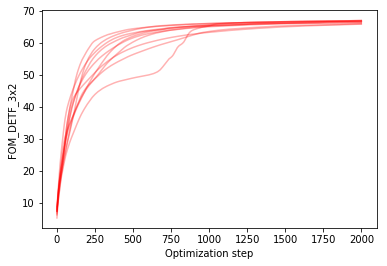

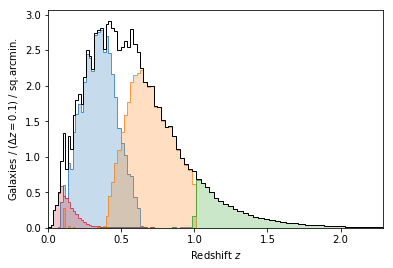

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 3000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=84.664 (max=84.664) after 750 steps.
  score=86.687 (max=86.713) after 1500 steps.
  score=87.530 (max=87.550) after 2250 steps.
  score=87.957 (max=87.963) after 3000 steps.
trial 1/10: score=87.957 (max=87.963) after 3000 steps.
  score=81.241 (max=87.963) after 750 steps.
  score=84.082 (max=87.963) after 1500 steps.
  score=85.000 (max=87.963) after 2250 steps.
  score=85.487 (max=87.963) after 3000 steps.
trial 2/10: score=85.487 (max=87.963) after 3000 steps.
  score=80.212 (max=87.963) after 750 steps.
  score=83.715 (max=87.963) after 1500 steps.
  score=85.108 (max=87.963) after 2250 steps.
  score=85.754 (max=87.963) after 3000 steps.
trial 3/10: score=85.754 (max=87.963) after 3000 steps.
  score=83.268 (max=87.963) after 750 steps.
  score=86.281 (max=87.963) after 1500 steps.
  score=87.456 (max=87.963) after 2250 steps.
  score=

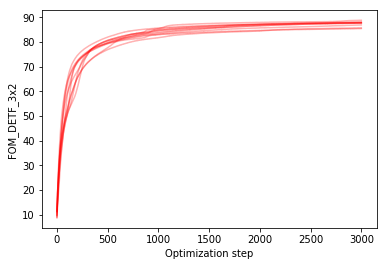

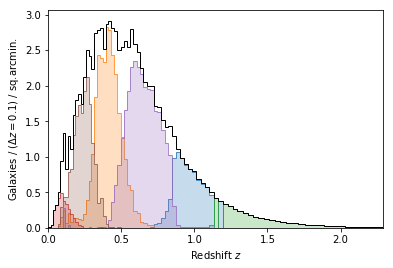

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 4000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=97.727 (max=97.765) after 1000 steps.
  score=103.029 (max=103.062) after 2000 steps.
  score=104.074 (max=104.074) after 3000 steps.
  score=104.835 (max=104.858) after 4000 steps.
trial 1/10: score=104.835 (max=104.858) after 4000 steps.
  score=96.247 (max=104.858) after 1000 steps.
  score=100.355 (max=104.858) after 2000 steps.
  score=102.420 (max=104.858) after 3000 steps.
  score=103.161 (max=104.858) after 4000 steps.
trial 2/10: score=103.161 (max=104.858) after 4000 steps.
  score=93.226 (max=104.858) after 1000 steps.
  score=98.151 (max=104.858) after 2000 steps.
  score=100.458 (max=104.858) after 3000 steps.
  score=102.285 (max=104.858) after 4000 steps.
trial 3/10: score=102.285 (max=104.858) after 4000 steps.
  score=95.660 (max=104.858) after 1000 steps.
  score=99.745 (max=104.858) after 2000 steps.
  score=101.735 (max=10

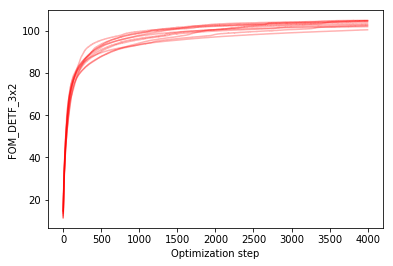

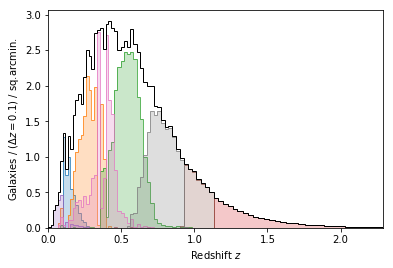

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 5000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=109.943 (max=109.943) after 1250 steps.
  score=116.768 (max=116.769) after 2500 steps.
  score=119.791 (max=119.804) after 3750 steps.
  score=121.621 (max=121.629) after 5000 steps.
trial 1/10: score=121.621 (max=121.629) after 5000 steps.
  score=112.180 (max=121.629) after 1250 steps.
  score=115.792 (max=121.629) after 2500 steps.
  score=118.124 (max=121.629) after 3750 steps.
  score=119.421 (max=121.629) after 5000 steps.
trial 2/10: score=119.421 (max=121.629) after 5000 steps.
  score=111.035 (max=121.629) after 1250 steps.
  score=115.830 (max=121.629) after 2500 steps.
  score=117.339 (max=121.629) after 3750 steps.
  score=118.810 (max=121.629) after 5000 steps.
trial 3/10: score=118.810 (max=121.629) after 5000 steps.
  score=111.987 (max=121.629) after 1250 steps.
  score=117.426 (max=121.629) after 2500 steps.
  score=119.242

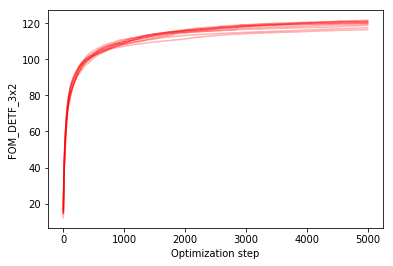

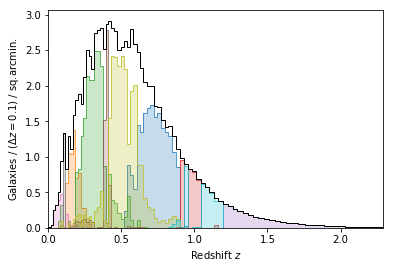

In [21]:
run_study('results/direct-detf', optimize_direct)

## Optimize redshift bins using features

In [33]:
def optimize_bins(nbin, groups, ntrial, nsteps, eta, transform, metric, method, seed, init_data=init_data):
    _, _, _, zhist, _ = load_groups(groups + '.npz')
    ngrp, nzin = zhist.shape
    nzout = len(init_data[0]) - 1
    assert nzin % nzout == 0
    downsampling = nzin // nzout
    if downsampling > 1:
        print(f'Downsampling by {downsampling}.')
        zhist = zhist.reshape(ngrp, nzout, downsampling).sum(axis=-1)
    mixing = jnp.array(zhist / zhist.sum())
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Running job with {'groups': 'group_emd_80_300', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.752 (max=18.752) after 375 steps.
  score=19.682 (max=19.682) after 750 steps.
  score=20.034 (max=20.035) after 1125 steps.
  score=20.168 (max=20.169) after 1500 steps.
trial 1/10: score=20.168 (max=20.169) after 1500 steps.
  score=18.649 (max=20.169) after 375 steps.
  score=19.624 (max=20.169) after 750 steps.
  score=20.020 (max=20.169) after 1125 steps.
  score=20.167 (max=20.169) after 1500 steps.
trial 2/10: score=20.167 (max=20.169) after 1500 steps.
  score=18.570 (max=20.169) after 375 steps.
  score=19.670 (max=20.169) after 750 steps.
  score=20.039 (max=20.169) after 1125 steps.
  score=20.166 (max=20.169) after 1500 steps.
trial 3/10: score=20.166 (max=20.169) after 1500 steps.
  score=18.571 (max=20.169) after 375 steps.
  score=19.585 (max=20.169) after 750 steps.
  score=19.943 

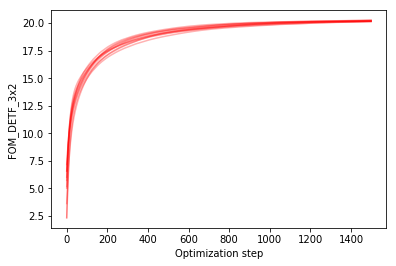

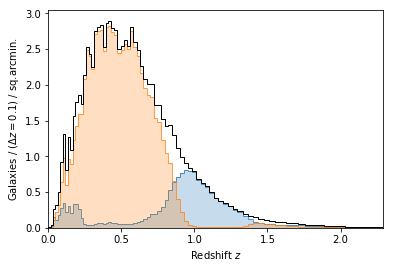

Running job with {'groups': 'group_emd_80_300', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.925 (max=52.925) after 750 steps.
  score=54.055 (max=54.057) after 1500 steps.
  score=54.387 (max=54.392) after 2250 steps.
  score=54.553 (max=54.554) after 3000 steps.
trial 1/10: score=54.553 (max=54.554) after 3000 steps.
  score=52.212 (max=54.554) after 750 steps.
  score=54.348 (max=54.554) after 1500 steps.
  score=54.758 (max=54.759) after 2250 steps.
  score=54.866 (max=54.866) after 3000 steps.
trial 2/10: score=54.866 (max=54.866) after 3000 steps.
  score=50.931 (max=54.866) after 750 steps.
  score=53.400 (max=54.866) after 1500 steps.
  score=54.073 (max=54.866) after 2250 steps.
  score=54.403 (max=54.866) after 3000 steps.
trial 3/10: score=54.403 (max=54.866) after 3000 steps.
  score=50.820 (max=54.866) after 750 steps.
  score=53.177 (max=54.866) after 1500 steps.
  score=54.

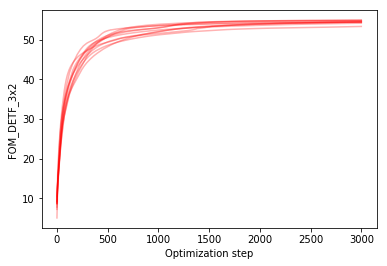

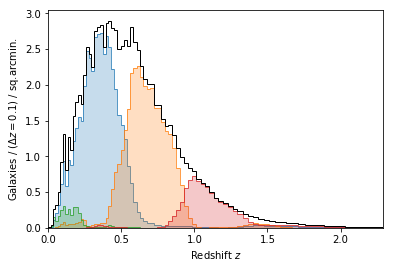

Running job with {'groups': 'group_emd_80_300', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.730 (max=63.750) after 1125 steps.
  score=66.081 (max=66.102) after 2250 steps.
  score=67.348 (max=67.348) after 3375 steps.
  score=68.057 (max=68.063) after 4500 steps.
trial 1/10: score=68.057 (max=68.063) after 4500 steps.
  score=64.464 (max=68.063) after 1125 steps.
  score=65.891 (max=68.063) after 2250 steps.
  score=66.519 (max=68.063) after 3375 steps.
  score=66.958 (max=68.063) after 4500 steps.
trial 2/10: score=66.958 (max=68.063) after 4500 steps.
  score=64.454 (max=68.063) after 1125 steps.
  score=66.114 (max=68.063) after 2250 steps.
  score=66.896 (max=68.063) after 3375 steps.
  score=67.387 (max=68.063) after 4500 steps.
trial 3/10: score=67.387 (max=68.063) after 4500 steps.
  score=64.627 (max=68.063) after 1125 steps.
  score=66.486 (max=68.063) after 2250 steps.
  score

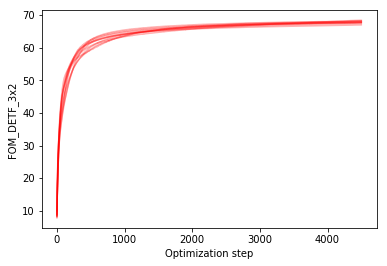

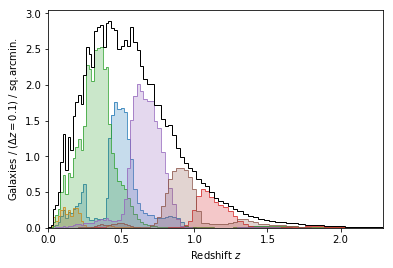

Running job with {'groups': 'group_emd_80_300', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.710 (max=71.710) after 1500 steps.
  score=74.673 (max=74.677) after 3000 steps.
  score=76.120 (max=76.138) after 4500 steps.
  score=76.729 (max=76.729) after 6000 steps.
trial 1/10: score=76.729 (max=76.729) after 6000 steps.
  score=74.573 (max=76.729) after 1500 steps.
  score=77.402 (max=77.409) after 3000 steps.
  score=78.391 (max=78.394) after 4500 steps.
  score=78.841 (max=78.843) after 6000 steps.
trial 2/10: score=78.841 (max=78.843) after 6000 steps.
  score=75.480 (max=78.843) after 1500 steps.
  score=77.484 (max=78.843) after 3000 steps.
  score=78.221 (max=78.843) after 4500 steps.
  score=78.680 (max=78.843) after 6000 steps.
trial 3/10: score=78.680 (max=78.843) after 6000 steps.
  score=73.366 (max=78.843) after 1500 steps.
  score=75.275 (max=78.843) after 3000 steps.
  score

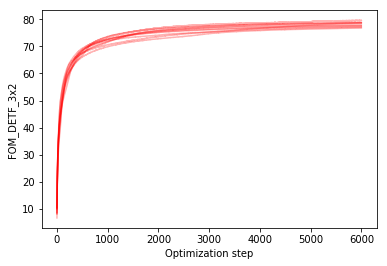

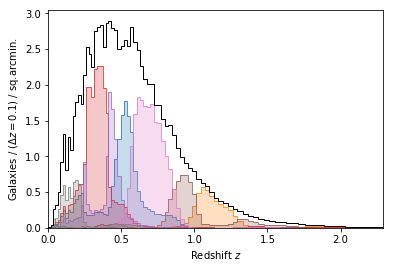

Running job with {'groups': 'group_emd_80_300', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.101 (max=81.120) after 1875 steps.
  score=85.266 (max=85.266) after 3750 steps.
  score=86.467 (max=86.471) after 5625 steps.
  score=87.029 (max=87.038) after 7500 steps.
trial 1/10: score=87.029 (max=87.038) after 7500 steps.
  score=81.465 (max=87.038) after 1875 steps.
  score=84.560 (max=87.038) after 3750 steps.
  score=86.085 (max=87.038) after 5625 steps.
  score=86.781 (max=87.038) after 7500 steps.
trial 2/10: score=86.781 (max=87.038) after 7500 steps.
  score=81.607 (max=87.038) after 1875 steps.
  score=84.219 (max=87.038) after 3750 steps.
  score=85.604 (max=87.038) after 5625 steps.
  score=86.362 (max=87.038) after 7500 steps.
trial 3/10: score=86.362 (max=87.038) after 7500 steps.
  score=79.166 (max=87.038) after 1875 steps.
  score=82.730 (max=87.038) after 3750 steps.
  scor

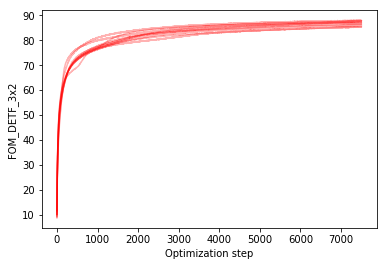

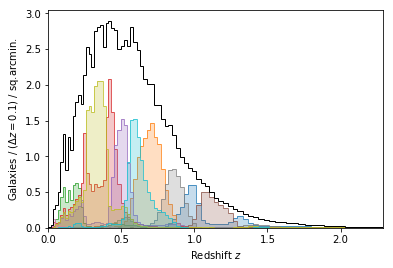

In [38]:
run_study('results/edm-300-detf', optimize_bins)

Running job with {'groups': 'group_emd_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.912 (max=18.912) after 375 steps.
  score=19.846 (max=19.846) after 750 steps.
  score=20.112 (max=20.112) after 1125 steps.
  score=20.240 (max=20.241) after 1500 steps.
trial 1/10: score=20.240 (max=20.241) after 1500 steps.
  score=18.660 (max=20.241) after 375 steps.
  score=19.697 (max=20.241) after 750 steps.
  score=20.038 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 2/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.688 (max=20.241) after 375 steps.
  score=19.695 (max=20.241) after 750 steps.
  score=20.051 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 3/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.411 (max=20.241) after 375 steps.
  score=19.536 (max=20.241) after 750 steps.
  score=19.980 

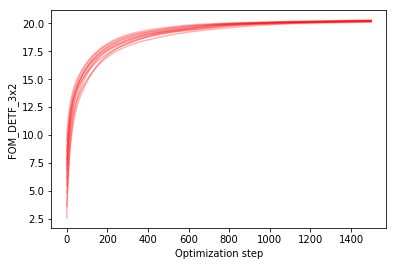

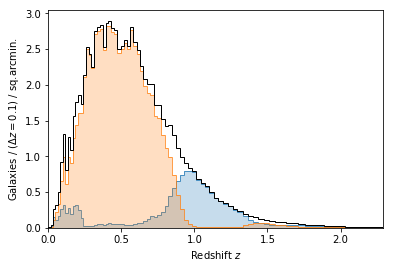

Running job with {'groups': 'group_emd_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=49.656 (max=49.657) after 750 steps.
  score=51.712 (max=51.712) after 1500 steps.
  score=52.510 (max=52.513) after 2250 steps.
  score=53.238 (max=53.240) after 3000 steps.
trial 1/10: score=53.238 (max=53.240) after 3000 steps.
  score=52.426 (max=53.240) after 750 steps.
  score=53.688 (max=53.696) after 1500 steps.
  score=54.145 (max=54.147) after 2250 steps.
  score=54.365 (max=54.367) after 3000 steps.
trial 2/10: score=54.365 (max=54.367) after 3000 steps.
  score=49.246 (max=54.367) after 750 steps.
  score=51.540 (max=54.367) after 1500 steps.
  score=52.777 (max=54.367) after 2250 steps.
  score=54.332 (max=54.367) after 3000 steps.
trial 3/10: score=54.332 (max=54.367) after 3000 steps.
  score=51.126 (max=54.367) after 750 steps.
  score=53.829 (max=54.367) after 1500 steps.
  score=54.

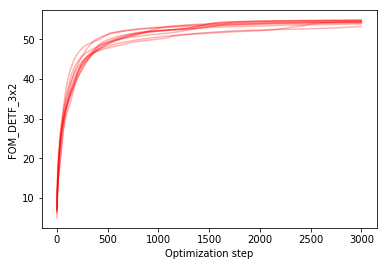

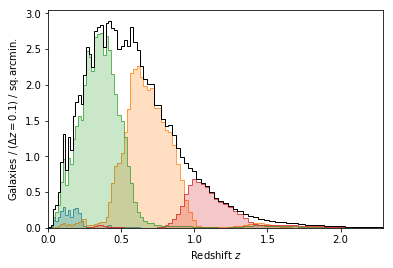

Running job with {'groups': 'group_emd_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.338 (max=65.345) after 1125 steps.
  score=66.816 (max=66.816) after 2250 steps.
  score=67.453 (max=67.453) after 3375 steps.
  score=67.781 (max=67.798) after 4500 steps.
trial 1/10: score=67.781 (max=67.798) after 4500 steps.
  score=65.428 (max=67.798) after 1125 steps.
  score=66.856 (max=67.798) after 2250 steps.
  score=67.475 (max=67.798) after 3375 steps.
  score=67.871 (max=67.877) after 4500 steps.
trial 2/10: score=67.871 (max=67.877) after 4500 steps.
  score=65.787 (max=67.877) after 1125 steps.
  score=67.421 (max=67.877) after 2250 steps.
  score=67.858 (max=67.882) after 3375 steps.
  score=68.245 (max=68.257) after 4500 steps.
trial 3/10: score=68.245 (max=68.257) after 4500 steps.
  score=64.001 (max=68.257) after 1125 steps.
  score=66.737 (max=68.257) after 2250 steps.
  score

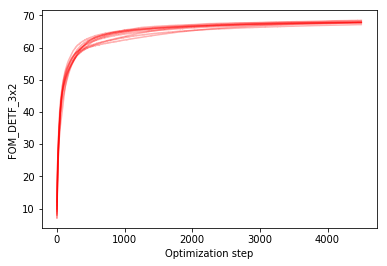

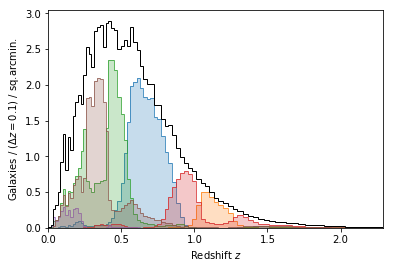

Running job with {'groups': 'group_emd_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.000 (max=71.053) after 1500 steps.
  score=73.854 (max=73.865) after 3000 steps.
  score=75.633 (max=75.649) after 4500 steps.
  score=76.310 (max=76.352) after 6000 steps.
trial 1/10: score=76.310 (max=76.352) after 6000 steps.
  score=75.798 (max=76.352) after 1500 steps.
  score=77.366 (max=77.458) after 3000 steps.
  score=77.988 (max=78.132) after 4500 steps.
  score=78.784 (max=78.993) after 6000 steps.
trial 2/10: score=78.784 (max=78.993) after 6000 steps.
  score=73.588 (max=78.993) after 1500 steps.
  score=76.105 (max=78.993) after 3000 steps.
  score=76.865 (max=78.993) after 4500 steps.
  score=77.243 (max=78.993) after 6000 steps.
trial 3/10: score=77.243 (max=78.993) after 6000 steps.
  score=75.180 (max=78.993) after 1500 steps.
  score=77.113 (max=78.993) after 3000 steps.
  score

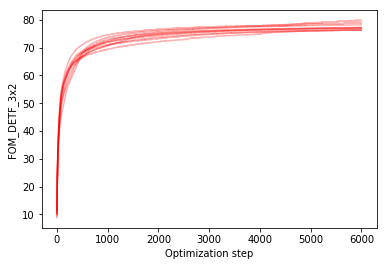

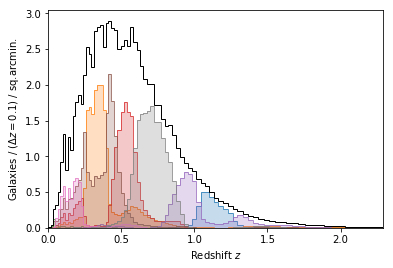

Running job with {'groups': 'group_emd_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=80.462 (max=80.642) after 1875 steps.
  score=83.813 (max=84.048) after 3750 steps.
  score=85.579 (max=85.579) after 5625 steps.
  score=86.167 (max=86.279) after 7500 steps.
trial 1/10: score=86.167 (max=86.279) after 7500 steps.
  score=81.119 (max=86.279) after 1875 steps.
  score=83.277 (max=86.279) after 3750 steps.
  score=84.266 (max=86.279) after 5625 steps.
  score=84.842 (max=86.279) after 7500 steps.
trial 2/10: score=84.842 (max=86.279) after 7500 steps.
  score=79.266 (max=86.279) after 1875 steps.
  score=80.829 (max=86.279) after 3750 steps.
  score=82.854 (max=86.279) after 5625 steps.
  score=85.485 (max=86.279) after 7500 steps.
trial 3/10: score=85.485 (max=86.279) after 7500 steps.
  score=83.282 (max=86.279) after 1875 steps.
  score=85.747 (max=86.279) after 3750 steps.
  scor

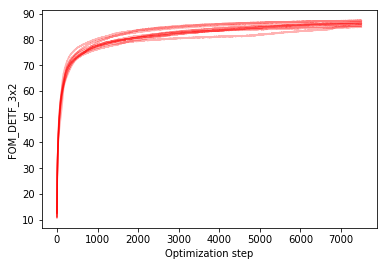

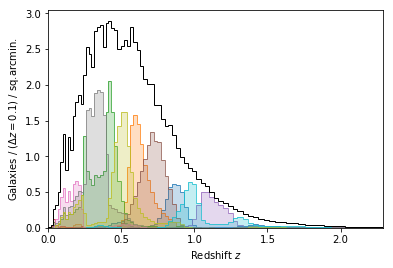

In [39]:
run_study('results/edm-150-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.403 (max=18.403) after 375 steps.
  score=19.646 (max=19.646) after 750 steps.
  score=20.063 (max=20.063) after 1125 steps.
  score=20.204 (max=20.205) after 1500 steps.
trial 1/10: score=20.204 (max=20.205) after 1500 steps.
  score=18.906 (max=20.205) after 375 steps.
  score=19.828 (max=20.205) after 750 steps.
  score=20.141 (max=20.205) after 1125 steps.
  score=20.235 (max=20.237) after 1500 steps.
trial 2/10: score=20.235 (max=20.237) after 1500 steps.
  score=19.090 (max=20.237) after 375 steps.
  score=20.009 (max=20.237) after 750 steps.
  score=20.207 (max=20.237) after 1125 steps.
  score=20.276 (max=20.278) after 1500 steps.
trial 3/10: score=20.276 (max=20.278) after 1500 steps.
  score=18.993 (max=20.278) after 375 steps.
  score=19.902 (max=20.278) after 750 steps.
  score=20.167 

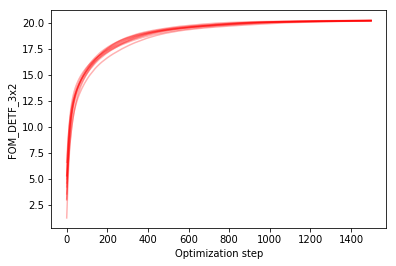

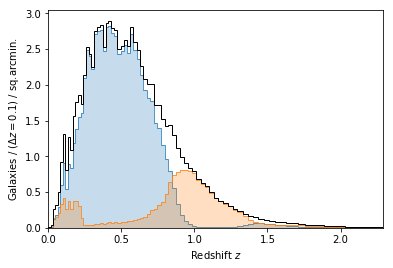

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=53.153 (max=53.153) after 750 steps.
  score=54.100 (max=54.100) after 1500 steps.
  score=54.398 (max=54.398) after 2250 steps.
  score=54.568 (max=54.574) after 3000 steps.
trial 1/10: score=54.568 (max=54.574) after 3000 steps.
  score=51.993 (max=54.574) after 750 steps.
  score=53.623 (max=54.574) after 1500 steps.
  score=54.124 (max=54.574) after 2250 steps.
  score=54.363 (max=54.574) after 3000 steps.
trial 2/10: score=54.363 (max=54.574) after 3000 steps.
  score=49.755 (max=54.574) after 750 steps.
  score=52.235 (max=54.574) after 1500 steps.
  score=54.183 (max=54.574) after 2250 steps.
  score=54.602 (max=54.603) after 3000 steps.
trial 3/10: score=54.602 (max=54.603) after 3000 steps.
  score=49.422 (max=54.603) after 750 steps.
  score=52.000 (max=54.603) after 1500 steps.
  score=54.

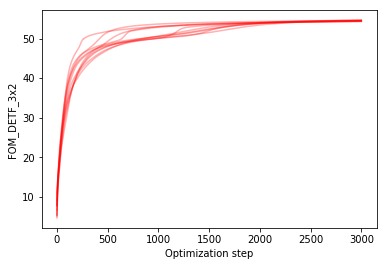

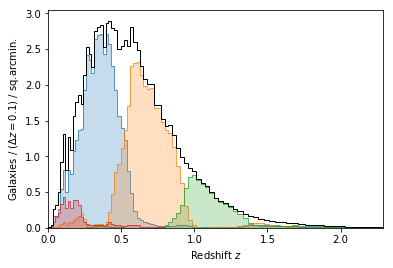

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=66.275 (max=66.275) after 1125 steps.
  score=67.699 (max=67.704) after 2250 steps.
  score=68.461 (max=68.465) after 3375 steps.
  score=69.040 (max=69.040) after 4500 steps.
trial 1/10: score=69.040 (max=69.040) after 4500 steps.
  score=66.566 (max=69.040) after 1125 steps.
  score=68.104 (max=69.040) after 2250 steps.
  score=68.605 (max=69.040) after 3375 steps.
  score=68.992 (max=69.040) after 4500 steps.
trial 2/10: score=68.992 (max=69.040) after 4500 steps.
  score=64.093 (max=69.040) after 1125 steps.
  score=66.990 (max=69.040) after 2250 steps.
  score=67.988 (max=69.040) after 3375 steps.
  score=68.420 (max=69.040) after 4500 steps.
trial 3/10: score=68.420 (max=69.040) after 4500 steps.
  score=62.498 (max=69.040) after 1125 steps.
  score=65.671 (max=69.040) after 2250 steps.
  score

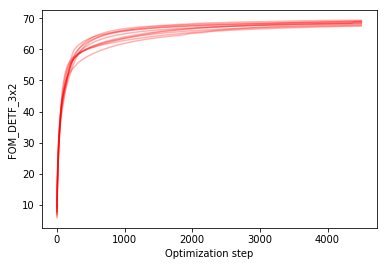

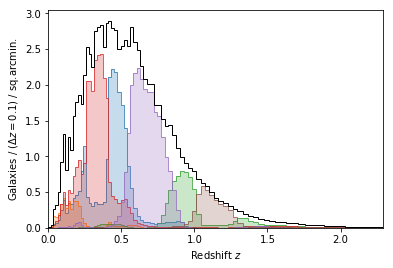

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=72.935 (max=72.935) after 1500 steps.
  score=75.879 (max=75.891) after 3000 steps.
  score=76.783 (max=76.800) after 4500 steps.
  score=77.156 (max=77.156) after 6000 steps.
trial 1/10: score=77.156 (max=77.156) after 6000 steps.
  score=73.506 (max=77.156) after 1500 steps.
  score=76.039 (max=77.156) after 3000 steps.
  score=76.799 (max=77.156) after 4500 steps.
  score=77.150 (max=77.156) after 6000 steps.
trial 2/10: score=77.150 (max=77.156) after 6000 steps.
  score=73.964 (max=77.156) after 1500 steps.
  score=75.997 (max=77.156) after 3000 steps.
  score=76.706 (max=77.156) after 4500 steps.
  score=77.112 (max=77.156) after 6000 steps.
trial 3/10: score=77.112 (max=77.156) after 6000 steps.
  score=73.583 (max=77.156) after 1500 steps.
  score=75.962 (max=77.156) after 3000 steps.
  score

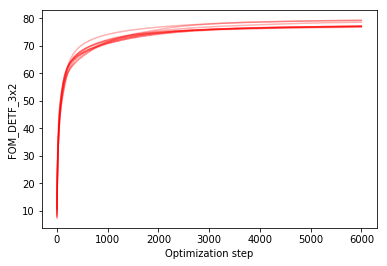

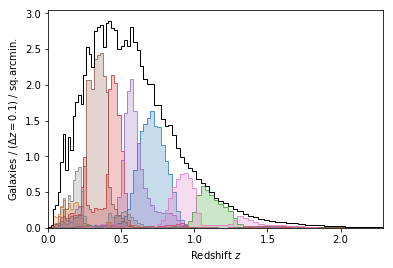

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=82.099 (max=82.110) after 1875 steps.
  score=85.686 (max=85.687) after 3750 steps.
  score=86.912 (max=86.939) after 5625 steps.
  score=87.603 (max=87.616) after 7500 steps.
trial 1/10: score=87.603 (max=87.616) after 7500 steps.


In [ ]:
run_study('results/cos-150-detf', optimize_bins)

## Sandbox

Assign bin labels to a sample based on optimized weights:

In [67]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels4 = get_labels(zbuz, wbest4)

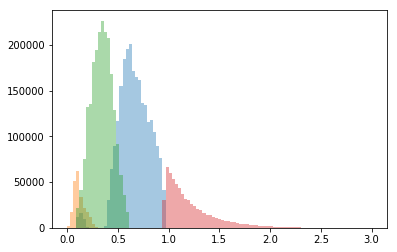

In [68]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz, labels4)

In [69]:
np.save('buzzard_labels4.npy', labels4.astype(np.uint8))